In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

# Resultado aproximado de nuestro Autoencoder

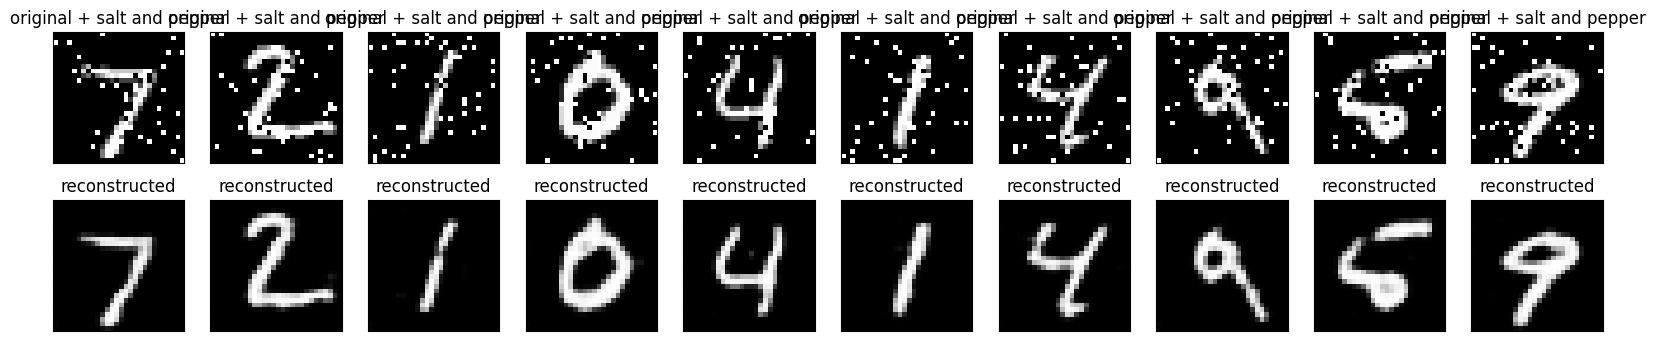

In [2]:
#Cargar el repositorio de MNIST con los numeros escritos a mano
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

"""
Convierte los valores de los píxeles en las imágenes (originalmente en un rango de 0 a 255) a un rango de 0 a 1 dividiendo por 255.
Además, cambia el tipo de datos a float32, lo cual es más adecuado para cálculos numéricos en redes neuronales


n_samples: número de imágenes de entrenamiento.
height: altura de cada imagen (p. ej., 28 para MNIST).
width: ancho de cada imagen (p. ej., 28 para MNIST).
1: canal de color (escala de grises).
"""

(60000, 28, 28, 1)


'\nConvierte los valores de los píxeles en las imágenes (originalmente en un rango de 0 a 255) a un rango de 0 a 1 dividiendo por 255.\nAdemás, cambia el tipo de datos a float32, lo cual es más adecuado para cálculos numéricos en redes neuronales\n\n\nn_samples: número de imágenes de entrenamiento.\nheight: altura de cada imagen (p. ej., 28 para MNIST).\nwidth: ancho de cada imagen (p. ej., 28 para MNIST).\n1: canal de color (escala de grises).\n'

## Fn para agregar ruido sal y pimienta

In [4]:
def add_salt_n_pepper(img, noise_factor):
    """
    Agrega ruido de sal y pimienta a una imagen.

    El ruido de sal y pimienta reemplaza aleatoriamente los valores de algunos 
    píxeles en una imagen con valores de intensidad máxima (sal) o mínima (pimienta), 
    simulando interferencia. Esta función es útil para aumentar datos y mejorar 
    la robustez de los modelos ante ruido.

    Parámetros:
    ----------
    img : tf.Tensor
        Imagen de entrada representada como un tensor. Normalmente debe estar 
        en un rango [0, 1].
    noise_factor : float
        Proporción de ruido a agregar. Valores más altos generan más ruido, y 
        valores cercanos a 0 dejan la imagen casi sin cambios.

    Retorna:
    -------
    tf.Tensor
        La imagen resultante con ruido de sal y pimienta aplicado.
    """

    img_out = tf.identity(img)
    
    treshold = 1 - noise_factor
    noise = tf.random.uniform(shape=tf.shape(img), minval=0., maxval=1.)
    
    #sal
    img_out = tf.where(noise < noise_factor, 1.0, img_out)
    
    #pimienta
    img_out = tf.where(noise > treshold, 0.0, img_out)
    
    return img_out

In [5]:
noise_factor = 0.05

x_train_noisy = add_salt_n_pepper(x_train, noise_factor)
x_test_noisy = add_salt_n_pepper(x_test, noise_factor)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

"""
aplica ruido de sal y pimienta a los conjuntos de datos de entrenamiento (x_train) y prueba (x_test) 
y luego asegura que los valores de los píxeles estén dentro del rango permitido ([0, 1]).
"""


'\naplica ruido de sal y pimienta a los conjuntos de datos de entrenamiento (x_train) y prueba (x_test) \ny luego asegura que los valores de los píxeles estén dentro del rango permitido ([0, 1]).\n'

### Look at imgs with noise

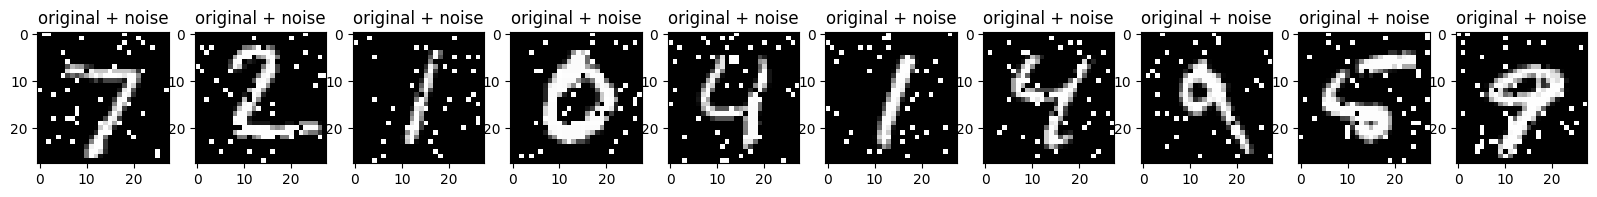

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### We define a convolutional autoencoder

In [7]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    
    
    # encoding part
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
    
    # decoding part

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [8]:
"""
Modelo de autoencoder para eliminar ruido de imágenes.

Este modelo está diseñado como un autoencoder convolucional. Consiste en dos partes:
un codificador (encoder) para comprimir las imágenes en una representación latente de menor dimensión 
y un decodificador (decoder) para reconstruir las imágenes originales desde la representación comprimida.

El modelo es útil para tareas de eliminación de ruido en imágenes (denoising), 
donde se entrena utilizando imágenes ruidosas como entrada y las imágenes originales 
como etiquetas de salida.

Métodos:
-------
__init__():
    Inicializa las capas del modelo, definiendo el codificador y el decodificador.

call(x):
    Define el flujo de datos a través del modelo. Toma una imagen de entrada, la procesa
    a través del codificador para obtener una representación latente comprimida y luego
    pasa esta representación al decodificador para reconstruir la imagen.

Atributos:
----------
encoder : tf.keras.Sequential
    Parte del modelo encargada de comprimir la imagen de entrada.
    Incluye:
    - Una capa de entrada con forma (28, 28, 1).
    - Dos capas Conv2D con activación ReLU, stride 2 y padding 'same'.

decoder : tf.keras.Sequential
    Parte del modelo encargada de reconstruir la imagen a partir de la representación comprimida.
    Incluye:
    - Dos capas Conv2DTranspose con activación ReLU, stride 2 y padding 'same'.
    - Una capa final Conv2D con activación sigmoide para generar la salida reconstruida.

Parámetros:
----------
x : tf.Tensor
    Imagen de entrada con dimensiones (batch_size, 28, 28, 1).

Retorna:
-------
tf.Tensor
    Imagen reconstruida con la misma forma que la entrada (batch_size, 28, 28, 1).
"""


"\nModelo de autoencoder para eliminar ruido de imágenes.\n\nEste modelo está diseñado como un autoencoder convolucional. Consiste en dos partes:\nun codificador (encoder) para comprimir las imágenes en una representación latente de menor dimensión \ny un decodificador (decoder) para reconstruir las imágenes originales desde la representación comprimida.\n\nEl modelo es útil para tareas de eliminación de ruido en imágenes (denoising), \ndonde se entrena utilizando imágenes ruidosas como entrada y las imágenes originales \ncomo etiquetas de salida.\n\nMétodos:\n-------\n__init__():\n    Inicializa las capas del modelo, definiendo el codificador y el decodificador.\n\ncall(x):\n    Define el flujo de datos a través del modelo. Toma una imagen de entrada, la procesa\n    a través del codificador para obtener una representación latente comprimida y luego\n    pasa esta representación al decodificador para reconstruir la imagen.\n\nAtributos:\n----------\nencoder : tf.keras.Sequential\n    

In [9]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# 3 epocas porque se quema mi compu

autoencoder.fit(x_train_noisy, x_train,
                epochs=3,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/3
1875/1875 [==============================] - 95s 49ms/step - loss: 0.1139 - val_loss: 0.1140
Epoch 2/3
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/3
1438/1875 [======================>.......] - ETA: 18s - loss: 0.1120

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

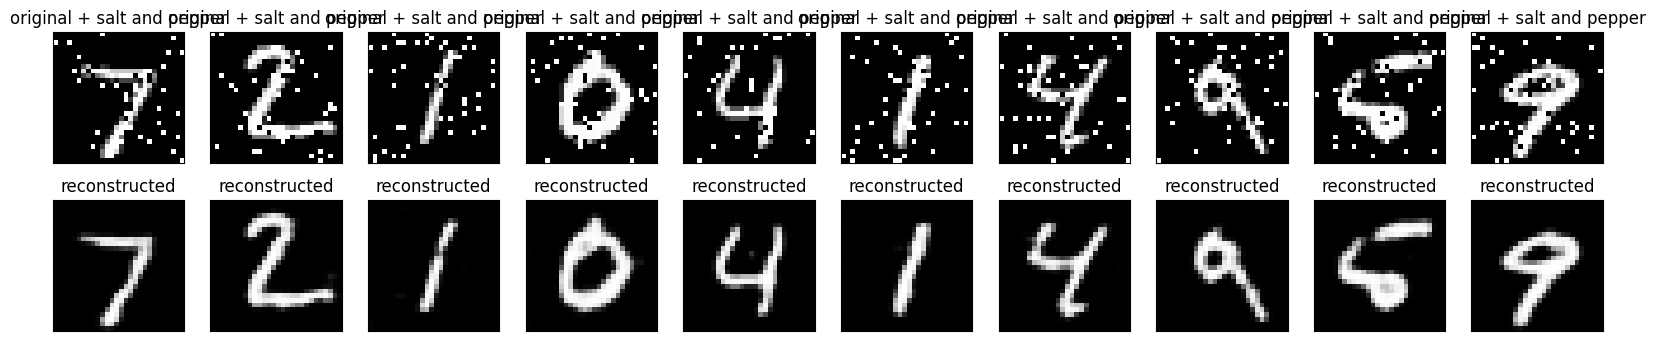

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + salt and pepper")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()